## NBA GM Signings Analysis - Part 3

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import requests
import time
import json
from bs4 import BeautifulSoup

In [31]:
pd.set_option('display.max_rows', None)

In [3]:
years = list(range(2022,2025))

### Pulling in Saved Data from Basketball Reference

In [44]:
winshares_df = pd.read_csv('C:/Users/kevin/Downloads/win shares stats 2022-2024.csv')

### Combine with Google Sheet Data

In [45]:
signings_df = pd.read_csv('C:/Users/kevin/Downloads/NBA GM Transaction Dataset - ALL TEAMS Signing Data 2022-2024.csv')

### Merging Data

In [46]:
merged_df = pd.merge(signings_df, winshares_df[['Player', 'Year', 'Tm', 'WS']], 
                     left_on=['Acquired Player', 'Season', 'Team Acquiring'], 
                     right_on=['Player', 'Year', 'Tm'], 
                     how='left')

In [47]:
signings_df['Acquired Player Win Shares Year 1'] = merged_df['WS']

In [48]:
merged_df_year2 = pd.merge(signings_df, winshares_df[['Player', 'Year', 'Tm', 'WS']], 
                     left_on=['Acquired Player', 'Year 2', 'Team Acquiring'], 
                     right_on=['Player', 'Year', 'Tm'], 
                     how='left')

In [49]:
signings_df['Acquired Player Win Shares Year 2'] = merged_df_year2['WS']

In [50]:
signings_df.isna().sum()

Season                                 0
Team Acquiring                         0
Acquired Player                        0
Team Losing                            1
Acquisition Type                       0
Acquiring GM                           0
Losing GM                             13
Year 2                                 0
Helper                                 0
AAV                                    0
One Year?                              0
Acquired Player Win Shares Year 1     35
Acquired Player Win Shares Year 2    168
dtype: int64

In [51]:
signings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Season                             201 non-null    int64  
 1   Team Acquiring                     201 non-null    object 
 2   Acquired Player                    201 non-null    object 
 3   Team Losing                        200 non-null    object 
 4   Acquisition Type                   201 non-null    object 
 5   Acquiring GM                       201 non-null    object 
 6   Losing GM                          188 non-null    object 
 7   Year 2                             201 non-null    int64  
 8   Helper                             201 non-null    object 
 9   AAV                                201 non-null    float64
 10  One Year?                          201 non-null    object 
 11  Acquired Player Win Shares Year 1  166 non-null    object 

From here it looks most players (168/201) in this dataset did not stay on the same team in year 2 after the acquisition.

In [12]:
signings_df[signings_df['Acquired Player'] == 'Lauri Markkanen']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,One Year?,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
121,2022,CLE,Lauri Markkanen,CHI,Signing,Koby Altman,Marc Eversley,2023,2022Lauri Markkanen,16.75,No,5.0,NaN


In [13]:
winshares_df[winshares_df['Player'] == 'Lauri Markkanen']

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
490,Lauri Markkanen,SF,24,CLE,61,1878,14.7,.582,.541,.226,...,19.5,2.7,2.3,5.0,.127,0.4,-0.1,0.4,1.1,2022
1249,Lauri Markkanen,PF,25,UTA,66,2273,22.1,.640,.446,.348,...,26.6,6.3,1.9,8.2,.173,4.9,-1.0,3.8,3.3,2023
1967,Lauri Markkanen,PF,26,UTA,55,1820,21.5,.631,.493,.311,...,25.0,5.2,0.9,6.2,.163,5.1,-1.5,3.6,2.6,2024


In [14]:
signings_df[signings_df['Acquired Player'] == 'Jalen Brunson']

,Season,Team Acquiring,Acquired Player,Team Losing,Acquisition Type,Acquiring GM,Losing GM,Year 2,Helper,AAV,One Year?,Acquired Player Win Shares Year 1,Acquired Player Win Shares Year 2
151,2023,NYK,Jalen Brunson,DAL,Signing,Scott Perry,Nico Harrison,2024,2023Jalen Brunson,26.0,No,8.7,11.2


In [15]:
winshares_df[winshares_df['Player'] == 'Jalen Brunson']

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Year
102,Jalen Brunson,SG,25,DAL,79,2524,17.1,.583,.250,.211,...,21.9,4.9,2.7,7.5,.143,0.9,0.0,0.9,1.9,2022
937,Jalen Brunson,PG,26,NYK,68,2379,21.2,.597,.269,.328,...,27.2,6.9,1.8,8.7,.175,4.4,-0.5,3.9,3.5,2023
1659,Jalen Brunson,PG,27,NYK,77,2726,23.4,.592,.319,.302,...,32.5,8.8,2.4,11.2,.198,6.3,-0.4,5.8,5.4,2024


The two examples shows that our Acquired Player BPM/WARP Year 2 calculation only pulls in if the player stayed with the team that acquired them in the second year. This is what we want - if they no longer have the player, the value they brought on doesn't help.

## Aggregation and Visualization

### Cost per Win Share

In [52]:
# Convert 'AAV' and 'Acquired Player BPM/WARP Year 1' to numeric, coercing errors to NaN
signings_df['AAV'] = pd.to_numeric(signings_df['AAV'], errors='coerce')
signings_df['Acquired Player Win Shares Year 1'] = pd.to_numeric(signings_df['Acquired Player Win Shares Year 1'], errors='coerce')

# Group by 'Team Acquiring' and calculate the sum of 'AAV' and 'Acquired Player BPM/WARP Year 1'
grouped_year1 = signings_df.groupby(['Season','Acquired Player','Acquiring GM', 'Team Acquiring']).agg({
    'AAV': 'sum',
    'Acquired Player Win Shares Year 1': 'sum'
})

# Calculate the ratio of AAV to Acquired Player BPM/WARP Year 1
grouped_year1['Cost of Win Share'] = grouped_year1['AAV'] / grouped_year1['Acquired Player Win Shares Year 1']

# Reset index for easier plotting
grouped_year1 = grouped_year1.reset_index()

In [53]:
grouped_year1

,Season,Acquired Player,Acquiring GM,Team Acquiring,AAV,Acquired Player Win Shares Year 1,Cost of Win Share
0,2022,Alex Caruso,Marc Eversley,CHI,9.25,2.0,4.625000
1,2022,Alex Len,Monte McNair,SAC,3.75,0.9,4.166667
2,2022,Alize Johnson,Marc Eversley,CHI,1.84,0.2,9.200000
3,2022,Andre Drummond,Daryl Morey,PHI,2.40,2.9,0.827586
4,2022,Andre Iguodala,Bob Myers,GSW,2.64,1.6,1.650000
5,2022,Austin Reaves,Rob Pelinka,LAL,0.60,2.9,0.206897
6,2022,Avery Bradley,Bob Myers,GSW,2.64,0.0,inf
7,2022,Ben McLemore,Joe Cronin,POR,2.40,0.8,3.000000
8,2022,Brad Wanamaker,Tommy Sheppard,WAS,1.67,0.1,16.700000
9,2022,Bryn Forbes,Brian Wright,SAS,4.50,0.7,6.428571


### Adding in Modeling Component - What Should the Cost of 1 Win Share Be?

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [55]:
grouped_year1.columns

Index(['Season', 'Acquired Player', 'Acquiring GM', 'Team Acquiring', 'AAV',
       'Acquired Player Win Shares Year 1', 'Cost of Win Share'],
      dtype='object')

In [56]:
features = grouped_year1['AAV'].values.reshape(-1, 1)
target = grouped_year1['Acquired Player Win Shares Year 1']

### Linear Regression

In [57]:
lm = LinearRegression()
lm.fit(features,target)

LinearRegression()

In [58]:
coeff_df = pd.DataFrame(lm.coef_,index=['AAV'],columns=['Coefficient'])
coeff_df

,Coefficient
AAV,0.186863


In [59]:
cost_win_share_modeled = 1 / coeff_df['Coefficient'].iloc[0]
cost_win_share_modeled

5.351509363853355

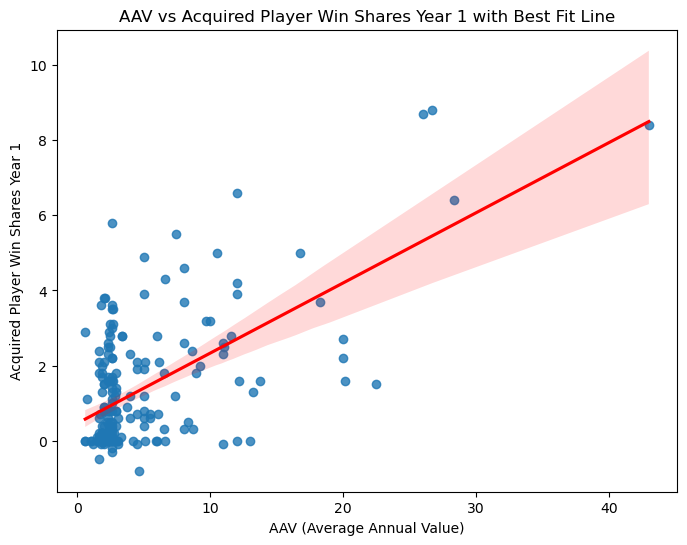

In [60]:
# Scatter plot with line of best fit
plt.figure(figsize=(8,6))
sns.regplot(x='AAV', y='Acquired Player Win Shares Year 1', data=grouped_year1, line_kws={"color": "red"})

# Adding labels and title
plt.xlabel('AAV (Average Annual Value)')
plt.ylabel('Acquired Player Win Shares Year 1')
plt.title('AAV vs Acquired Player Win Shares Year 1 with Best Fit Line')

# Show plot
plt.show()

The regression yields a cost per win share of $5.35 million. The raw calculation below is used to just gut check that number.

In [61]:
aav_sum = grouped_year1['AAV'].sum()
win_shares_sum = grouped_year1['Acquired Player Win Shares Year 1'].sum()

cost_win_share_raw = aav_sum / win_shares_sum
print(cost_win_share_raw)

3.5356699525374227


In [62]:
# Group by 'Season' and calculate the sum of 'AAV' and 'Acquired Player Win Shares Year 1' for each season
grouped_by_season = grouped_year1.groupby('Season').agg({
    'AAV': 'sum',
    'Acquired Player Win Shares Year 1': 'sum'
})

# Calculate cost per win share for each season
grouped_by_season['Cost Per Win Share'] = grouped_by_season['AAV'] / grouped_by_season['Acquired Player Win Shares Year 1']

print(grouped_by_season[['Cost Per Win Share']])

        Cost Per Win Share
Season                    
2022              3.410081
2023              3.240366
2024              3.999746


In [63]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = grouped_year1['Cost of Win Share'].quantile(0.25)
Q3 = grouped_year1['Cost of Win Share'].quantile(0.75)
IQR = Q3 - Q1  # Interquartile Range

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the DataFrame
filtered_df = grouped_year1[(grouped_year1['Cost of Win Share'] >= lower_bound) & 
                             (grouped_year1['Cost of Win Share'] <= upper_bound)]

std_cost = filtered_df['Cost of Win Share'].std()

In [64]:
std_cost

7.16021119663718

In [65]:
cost_win_share_modeled

5.351509363853355

In [66]:
# Define a grading function
def assign_grade(cost):
    if cost < 0:
        return 'F'
    elif cost >= cost_win_share_modeled - std_cost * 0.25 and cost <= cost_win_share_modeled + std_cost * 0.5:
        return 'C'
    elif cost > cost_win_share_modeled - std_cost * 0.5 and cost <= cost_win_share_modeled - std_cost * 0.25:
        return 'B'
    elif cost < cost_win_share_modeled - std_cost * 0.5:
        return 'A'
    elif cost > cost_win_share_modeled + std_cost * 0.5 and cost <= cost_win_share_modeled + std_cost * 2:
        return 'D'
    elif cost > cost_win_share_modeled + std_cost * 2:
        return 'F'

# Apply the grading function to the 'Cost of Win Share' column and create a new 'Grade' column
grouped_year1['Grade'] = grouped_year1['Cost of Win Share'].apply(assign_grade)

In [67]:
grouped_year1.to_csv('C:/Users/kevin/Downloads/first year acquired NBA players win shares.csv')

In [68]:
grouped_year1.sort_values(by='Grade')

,Season,Acquired Player,Acquiring GM,Team Acquiring,AAV,Acquired Player Win Shares Year 1,Cost of Win Share,Grade
151,2024,Derrick Jones Jr.,Nico Harrison,DAL,2.70,3.1,0.870968,A
113,2023,Josh Okogie,James Jones,PHO,2.50,2.8,0.892857,A
138,2024,Bol Bol,James Jones,PHO,2.50,1.6,1.562500,A
30,2022,George Hill,Jon Horst,MIL,4.00,2.3,1.739130,A
31,2022,Georges Niang,Daryl Morey,PHI,3.35,2.8,1.196429,A
33,2022,Hassan Whiteside,Justin Zanik,UTA,2.64,5.8,0.455172,A
77,2022,Tony Bradley,Marc Eversley,CHI,1.90,1.3,1.461538,A
35,2022,Isaiah Hartenstein,Michael Winger,LAC,7.45,5.5,1.354545,A
168,2024,Jaxson Hayes,Rob Pelinka,LAL,2.30,2.5,0.920000,A
38,2022,JaVale McGee,James Jones,PHO,5.00,4.9,1.020408,A


In [69]:
grouped_year1['Grade'].value_counts()

F    62
A    45
C    39
B    35
D    20
Name: Grade, dtype: int64

A guy like Jalen Brunson being a B here means this model isn't perfect. We would want to try do an exponential regression that reflects the fact that additional win shares at the top of the scale are worth much more than additional win shares at the bottom.

### Exponential Regression

In [35]:
import statsmodels.api as sm

In [36]:
# Step 1: Log-transform the dependent variable
grouped_year1['log_Win_Shares'] = np.log(grouped_year1['Acquired Player Win Shares Year 1'])

# Step 2: Set up the independent and dependent variables for regression
X = grouped_year1['AAV']
y = grouped_year1['log_Win_Shares']

# Add a constant to the independent variable for the regression intercept
X = sm.add_constant(X)

C:\Users\kevin\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\kevin\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
print(grouped_year1.isnull().sum())

Season                                0
Acquired Player                       0
Acquiring GM                          0
Team Acquiring                        0
AAV                                   0
Acquired Player Win Shares Year 1     0
Cost of Win Share                     0
Grade                                 0
log_Win_Shares                       10
dtype: int64


In [39]:
# Remove rows where 'log_Win_Shares' has NaN values
grouped_year1 = grouped_year1.dropna(subset=['log_Win_Shares'])

In [40]:
print(grouped_year1.isnull().sum())

Season                               0
Acquired Player                      0
Acquiring GM                         0
Team Acquiring                       0
AAV                                  0
Acquired Player Win Shares Year 1    0
Cost of Win Share                    0
Grade                                0
log_Win_Shares                       0
dtype: int64


In [41]:
# Step 3: Fit the linear model on the log-transformed dependent variable
model = sm.OLS(y, X).fit()

# Step 4: Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_Win_Shares   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 27 Oct 2024   Prob (F-statistic):                nan
Time:                        18:42:25   Log-Likelihood:                    nan
No. Observations:                 201   AIC:                               nan
Df Residuals:                     199   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

In [42]:
# Step 5: Use the model to predict the log values, then exponentiate them to return to the original scale
grouped_year1['Predicted_Win_Shares'] = np.exp(model.predict(X))

C:\Users\kevin\AppData\Local\Temp\ipykernel_24720\2494568596.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_year1['Predicted_Win_Shares'] = np.exp(model.predict(X))


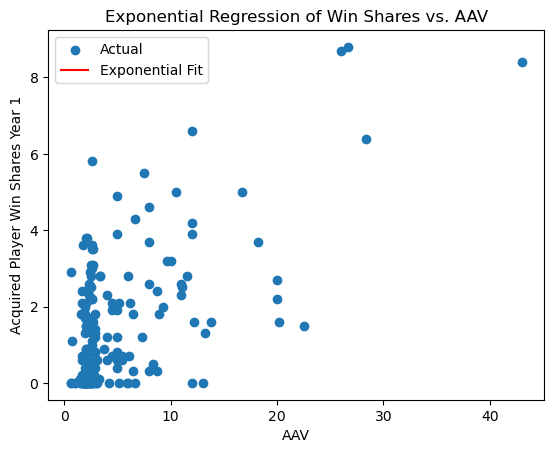

In [43]:
# Step 6: Plot the results
plt.scatter(grouped_year1['AAV'], grouped_year1['Acquired Player Win Shares Year 1'], label='Actual')
plt.plot(grouped_year1['AAV'], grouped_year1['Predicted_Win_Shares'], color='red', label='Exponential Fit')
plt.xlabel('AAV')
plt.ylabel('Acquired Player Win Shares Year 1')
plt.title('Exponential Regression of Win Shares vs. AAV')
plt.legend()
plt.show()